In [ ]:
!pip install pmdarima
!pip install prophet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from statsmodels.tools.eval_measures import rmse

In [ ]:
#base de dados - 01.03.2005 á 15.07.2024

df = pd.read_csv('/content/ibovespa-historical.csv', delimiter=',', encoding='utf-8')

In [ ]:
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,07/16/2024,"129,110","129,322","129,521","128,761",6.82B,-0.16%
1,07/15/2024,"129,321","128,898","129,485","128,723",5.83B,0.33%
2,07/12/2024,"128,897","128,293","129,015","128,002",7.21B,0.47%
3,07/11/2024,"128,294","127,221","128,326","127,221",7.97B,0.85%
4,07/10/2024,"127,218","127,109","127,769","126,928",8.15B,0.09%


In [ ]:
df.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [ ]:
#df['Price'] = df['Price'].astype(float)
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', dayfirst=True)

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-07-16,129110.0,129322.0,129521.0,128761.0,6.82B,-0.16%
1,2024-07-15,129321.0,128898.0,129485.0,128723.0,5.83B,0.33%
2,2024-07-12,128897.0,128293.0,129015.0,128002.0,7.21B,0.47%
3,2024-07-11,128294.0,127221.0,128326.0,127221.0,7.97B,0.85%
4,2024-07-10,127218.0,127109.0,127769.0,126928.0,8.15B,0.09%


In [ ]:
df.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                object
Change %            object
dtype: object

**Analise Exploratória dos Dados**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4838 non-null   datetime64[ns]
 1   Price     4838 non-null   float64       
 2   Open      4838 non-null   float64       
 3   High      4838 non-null   float64       
 4   Low       4838 non-null   float64       
 5   Vol.      4837 non-null   object        
 6   Change %  4838 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 264.7+ KB


In [ ]:
df.shape

(4838, 7)

In [ ]:
df_fechamento = df[['Date', 'Price']]

df_fechamento.set_index('Date', inplace=True)

df_fechamento.sort_index(inplace=True)

df_fechamento = df_fechamento.asfreq('B')

display(df_fechamento.tail())

<ipython-input-331-14dd8e8dd7ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fechamento.sort_index(inplace=True)


,Price
Date,
2024-07-10,127218.0
2024-07-11,128294.0
2024-07-12,128897.0
2024-07-15,129321.0
2024-07-16,129110.0


In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df.sort_index(inplace=True)

In [ ]:
df.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-07-10,127218.0,127109.0,127769.0,126928.0,8.15B,0.09%
2024-07-11,128294.0,127221.0,128326.0,127221.0,7.97B,0.85%
2024-07-12,128897.0,128293.0,129015.0,128002.0,7.21B,0.47%
2024-07-15,129321.0,128898.0,129485.0,128723.0,5.83B,0.33%
2024-07-16,129110.0,129322.0,129521.0,128761.0,6.82B,-0.16%


In [ ]:
df['Change %'] = df['Change %'].str.replace('%', '').str.replace(',', '.').astype(float)

In [ ]:
def convert_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '').replace(',', '.')) * 1e6
        elif 'K' in vol:
            return float(vol.replace('K', '').replace(',', '.')) * 1e3
        elif 'B' in vol:
            return float(vol.replace('B', '').replace(',', '.')) * 1e9
        return float(vol.replace(',', '.'))
    return vol

df['Vol.'] = df['Vol.'].apply(convert_volume)

In [ ]:
nulos = df.isnull().sum()
print(nulos)

Price       0
Open        0
High        0
Low         0
Vol.        1
Change %    0
dtype: int64


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object

<ipython-input-355-3566b5b9ac2c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Price'], color='purple')


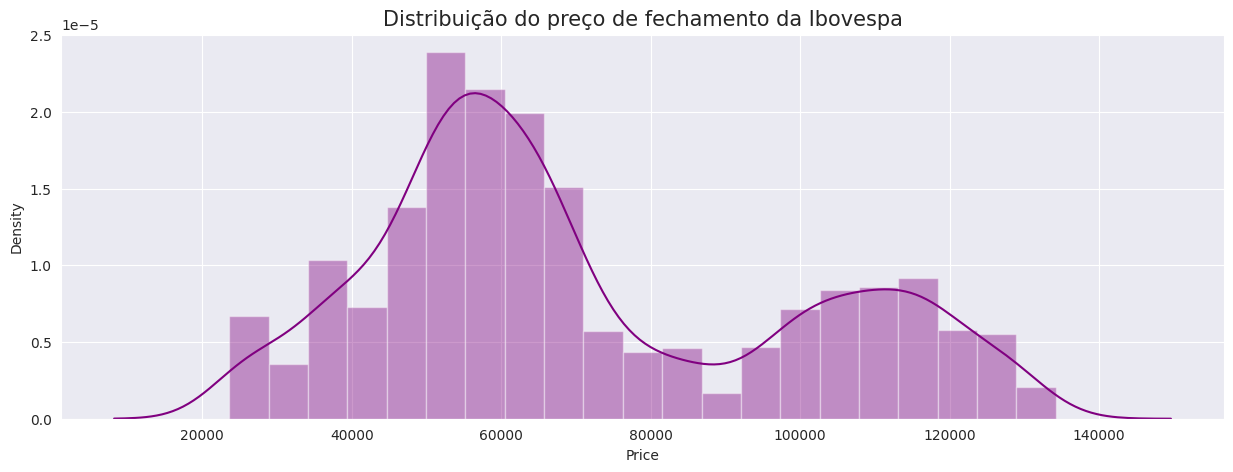

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(df['Price'], color='purple')
plt.title('Distribuição do preço de fechamento da Ibovespa',size=15);

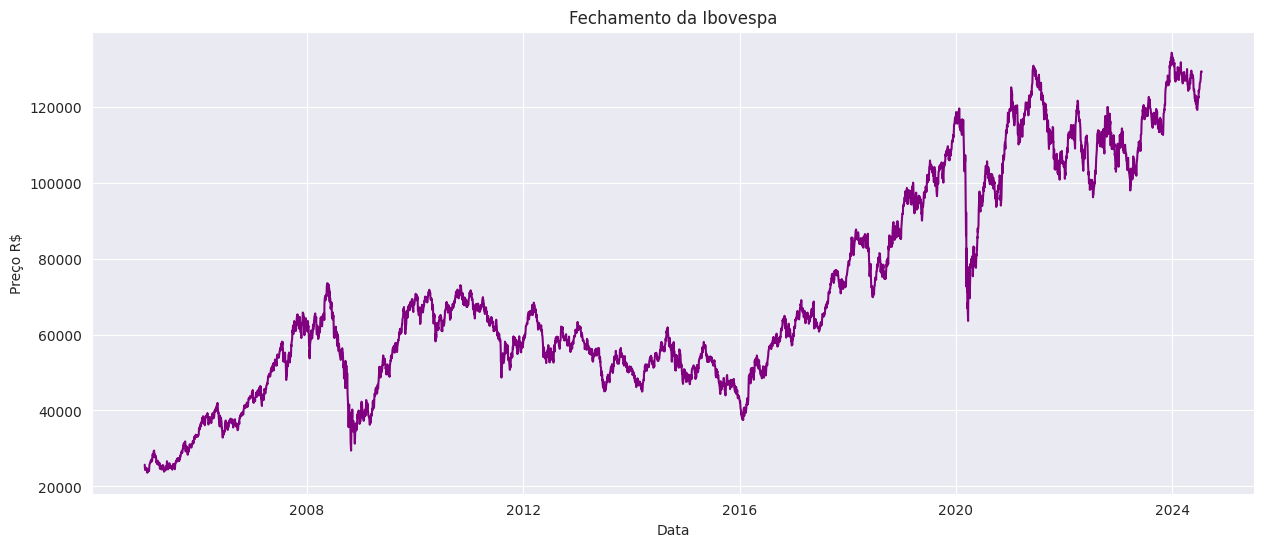

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df.Price, color= 'purple')
plt.title('Fechamento da Ibovespa')
plt.xlabel('Data')
plt.ylabel('Preço R$')
plt.show()

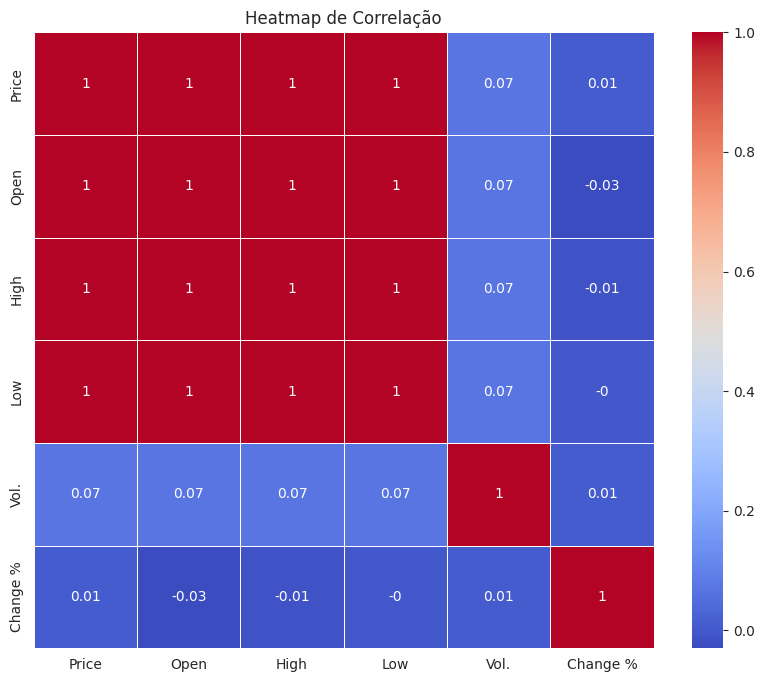

In [ ]:
correlacao = df.corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de Correlação')
plt.show()

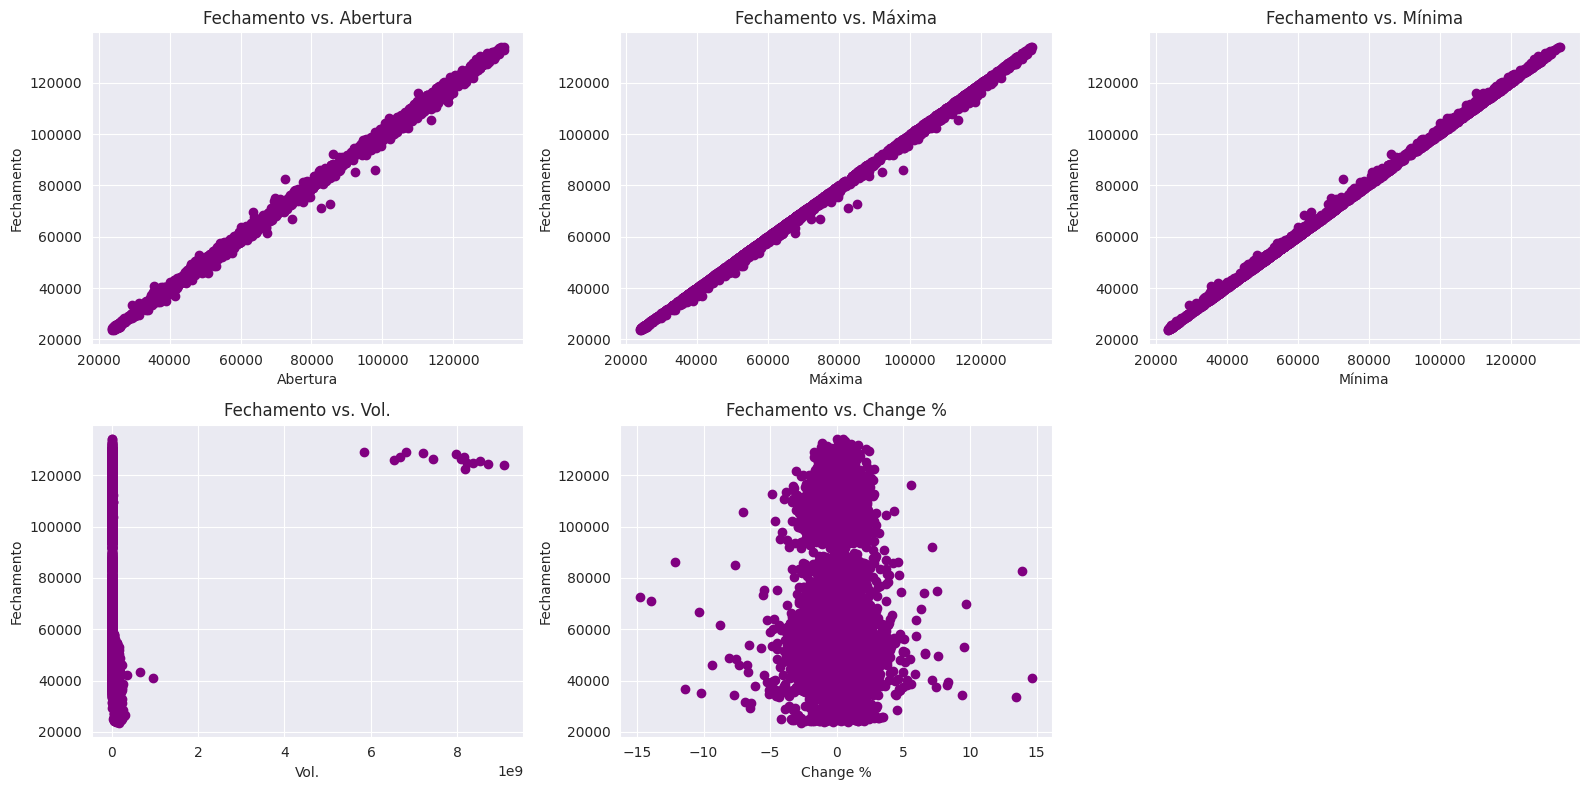

In [ ]:
# Gráficos de dispersão entre pares de variáveis numéricas
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.scatter(df['Open'], df['Price'], color='purple')
plt.title('Fechamento vs. Abertura')
plt.xlabel('Abertura')
plt.ylabel('Fechamento')

plt.subplot(2, 3, 2)
plt.scatter(df['High'], df['Price'], color='purple')
plt.title('Fechamento vs. Máxima')
plt.xlabel('Máxima')
plt.ylabel('Fechamento')

plt.subplot(2, 3, 3)
plt.scatter(df['Low'], df['Price'], color='purple')
plt.title('Fechamento vs. Mínima')
plt.xlabel('Mínima')
plt.ylabel('Fechamento')

plt.subplot(2, 3, 4)
plt.scatter(df['Vol.'], df['Price'], color='purple')
plt.title('Fechamento vs. Vol.')
plt.xlabel('Vol.')
plt.ylabel('Fechamento')

plt.subplot(2, 3, 5)
plt.scatter(df['Change %'], df['Price'], color='purple')
plt.title('Fechamento vs. Change %')
plt.xlabel('Change %')
plt.ylabel('Fechamento')

plt.tight_layout()
plt.show()

**Base de Treino e Teste**

In [ ]:
train_size = int(len(df_fechamento) * 0.80)
train, test = df_fechamento.iloc[:train_size], df_fechamento.iloc[train_size:]

In [ ]:
print(train['Price'].isna().sum())

211


In [ ]:
# Valores ausentes -  interpolação
train['Price'] = train['Price'].interpolate(method='linear')
print(train['Price'].isna().sum())

0


<ipython-input-362-095b4440ebb0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price'] = train['Price'].interpolate(method='linear')


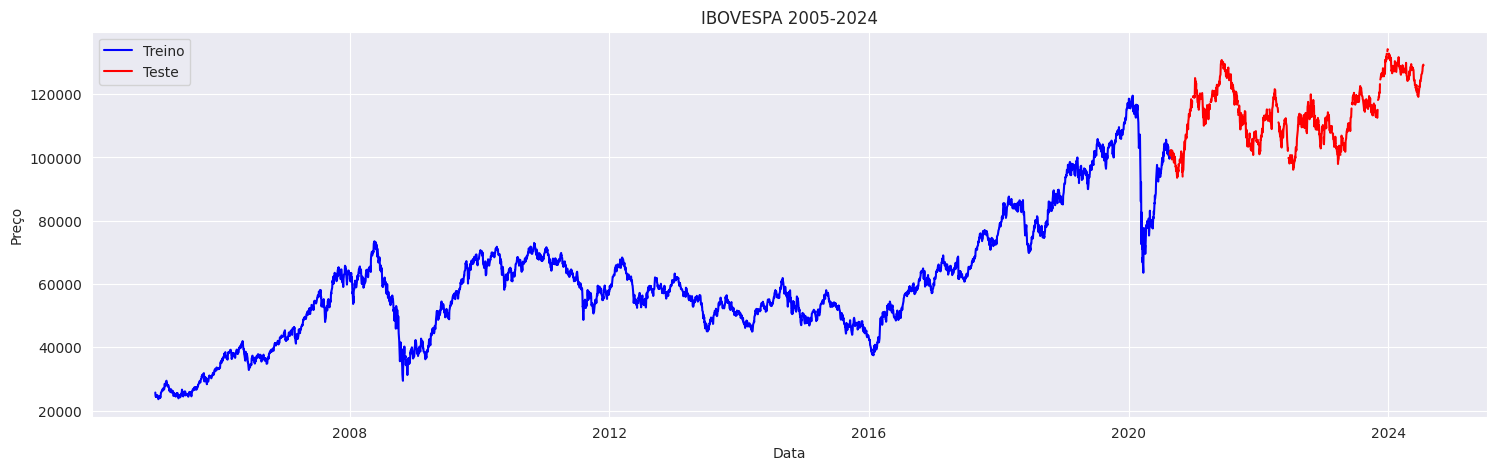

In [ ]:
plt.figure(figsize=(18,5))
plt.title('IBOVESPA 2005-2024')
plt.plot(train['Price'], color='b')
plt.plot(test['Price'], color='red')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

In [ ]:
resultados= seasonal_decompose(train, model='multiplicative', period=5)

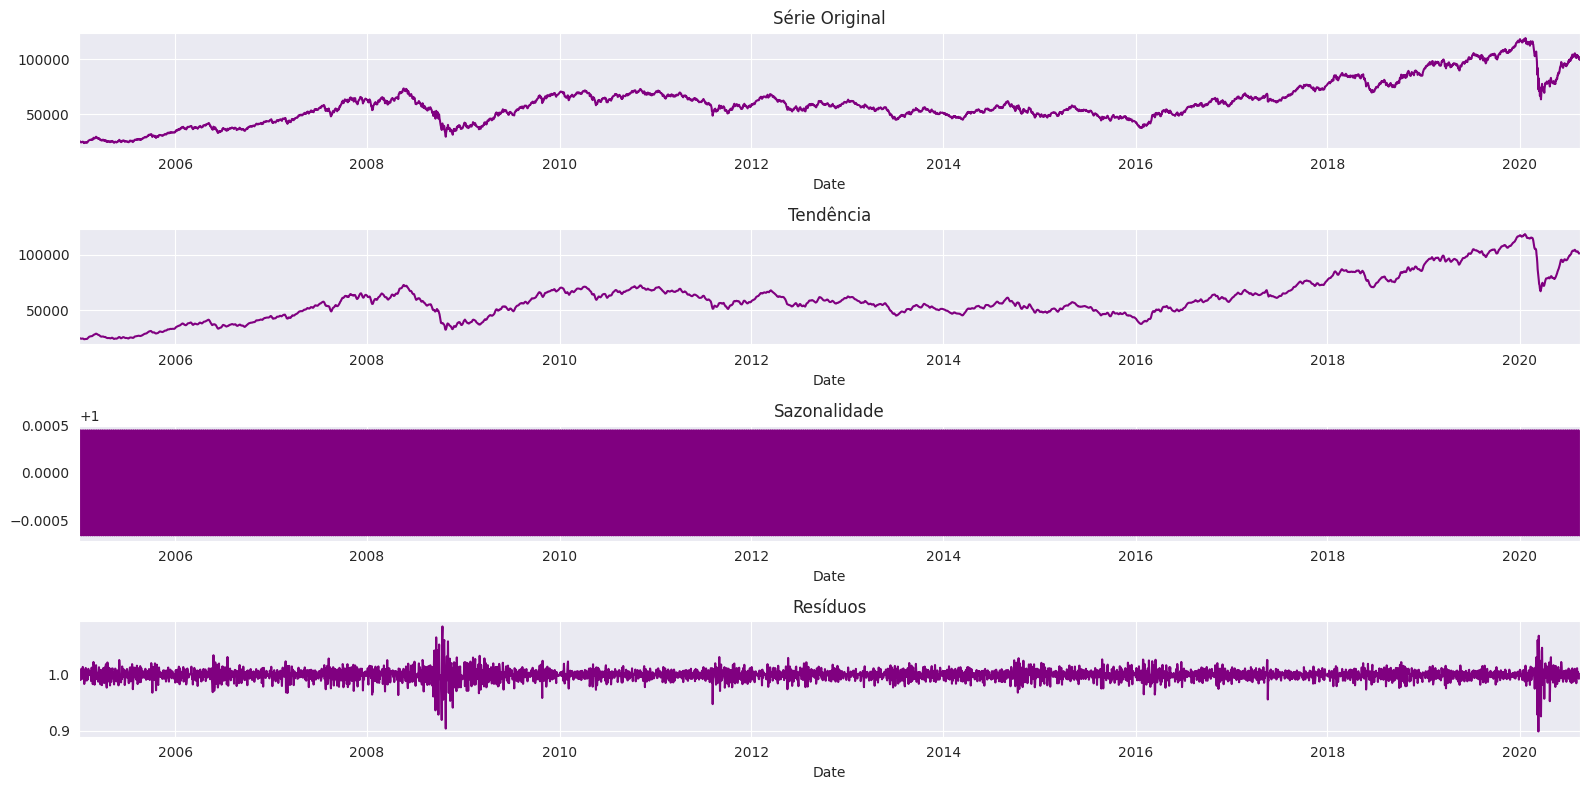

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 8))

resultados.observed.plot(ax=ax1, color='purple')
resultados.trend.plot(ax=ax2, color='purple')
resultados.seasonal.plot(ax=ax3, color='purple')
resultados.resid.plot(ax=ax4, color='purple')

ax1.set_title('Série Original')
ax2.set_title('Tendência')
ax3.set_title('Sazonalidade')
ax4.set_title('Resíduos')

plt.tight_layout()
plt.show()

In [ ]:
#Teste de Dickey-Fuller

sns.set_style('darkgrid')
resultado = adfuller(train['Price'])
print('Estatística ADF:', resultado[0])
print('Valor-p:', resultado[1])

if resultado[1] < 0.05:
    print('A série é estacionária (p-valor < 0.05)')
else:
    print('A série não é estacionária (p-valor > 0.05)')


Estatística ADF: -1.6942450568777085
Valor-p: 0.43408000941615477
A série não é estacionária (p-valor > 0.05)


**Transformando a série em estacionária**

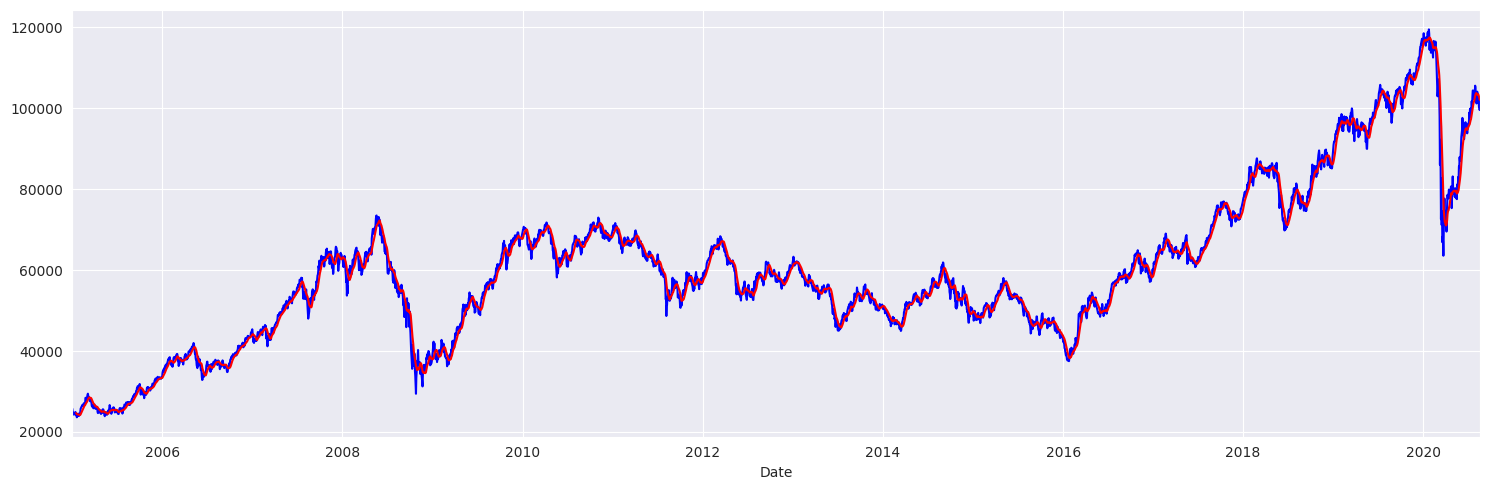

In [ ]:
ma= train.rolling(window=12).mean()

f, ax= plt.subplots(figsize=(15,5))
train.plot(ax=ax, color='b', legend=False)
ma.plot(ax=ax, color='red',  legend=False)
plt.tight_layout()
plt.show()

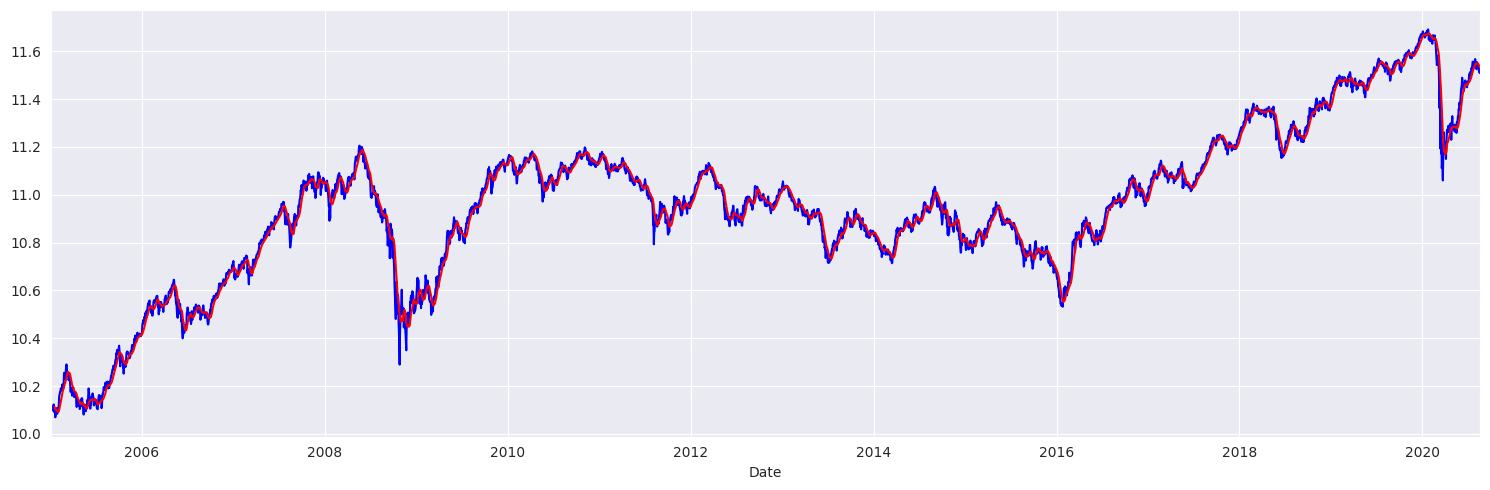

In [ ]:
df_log= np.log(train)
ma_log= df_log.rolling(window=12).mean()

f, ax= plt.subplots(figsize=(15,5))
df_log.plot(ax=ax, color='b', legend=False)
ma_log.plot(ax=ax, color='red',  legend=False)
plt.tight_layout()
plt.show()

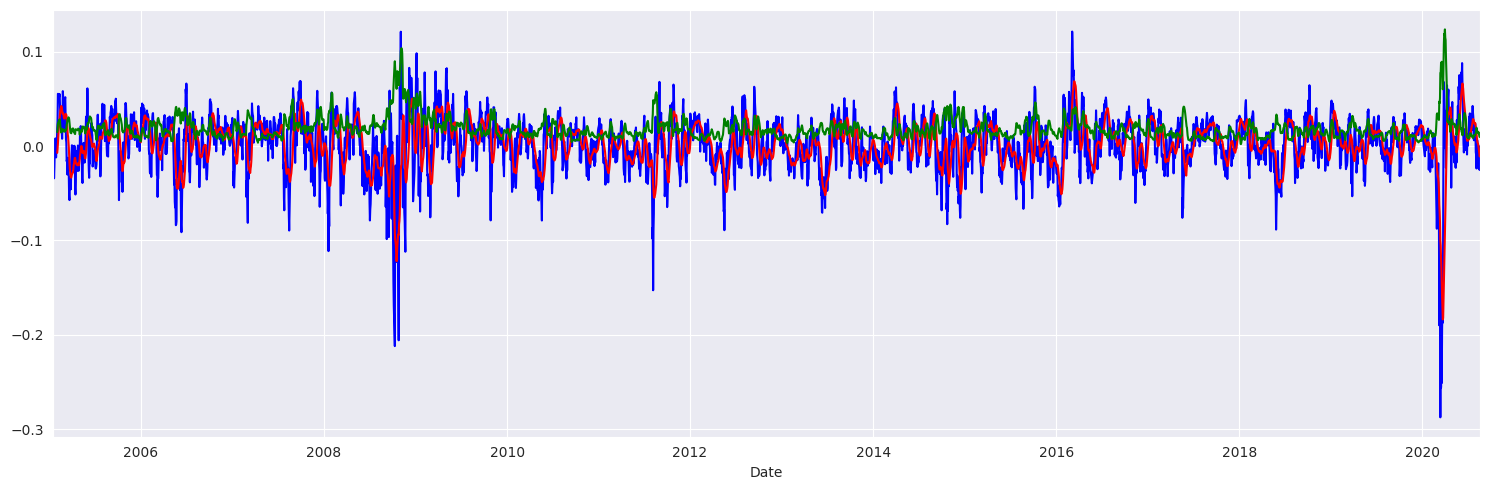

In [ ]:
df_s= (df_log - ma_log).dropna()

ma_s= df_s.rolling(12).mean()

std= df_s.rolling(12).std()


f, ax= plt.subplots(figsize=(15,5))
df_s.plot(ax=ax, color='b', legend=False)
ma_s.plot(ax=ax, color='r',  legend=False)
std.plot(ax=ax, color='g',  legend=False)
plt.tight_layout()
plt.show()


In [ ]:
#Teste de Dickey-Fuller (Após Suavização Logarítmica)

sns.set_style('darkgrid')
resultado_s = adfuller(df_s['Price'])
print('Estatística ADF:', resultado_s[0])
print('Valor-p:', resultado_s[1])

if resultado_s[1] < 0.05:
    print('A série é estacionária (p-valor < 0.05)')
else:
    print('A série não é estacionária (p-valor > 0.05)')

Estatística ADF: -12.026493135197592
Valor-p: 2.9407218125901763e-22
A série é estacionária (p-valor < 0.05)


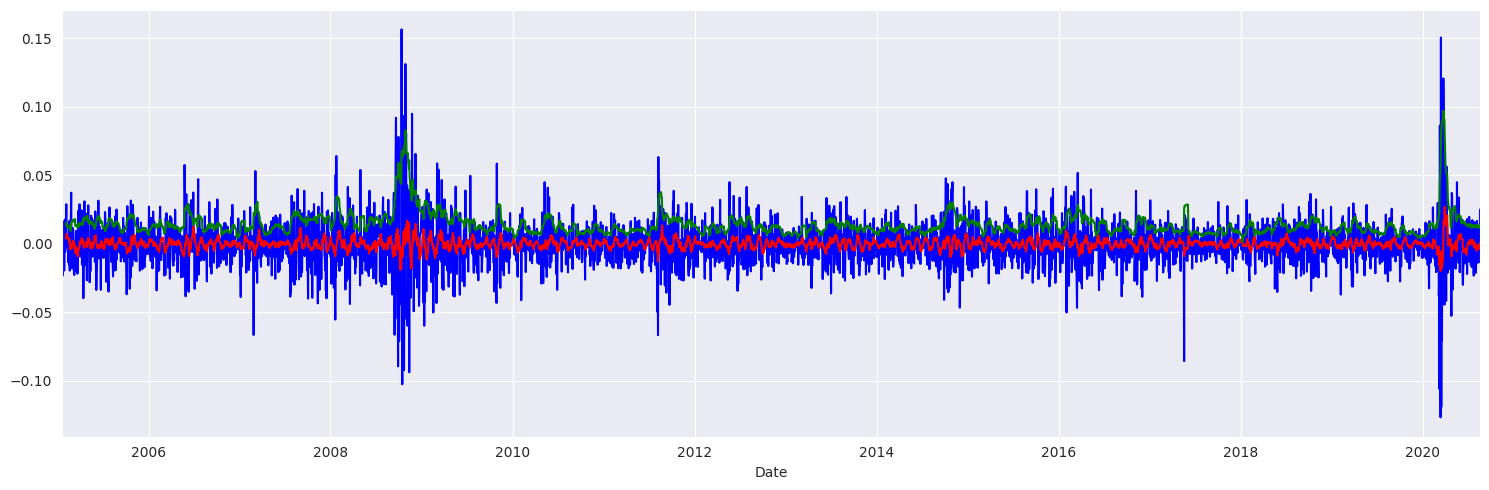

In [ ]:

df_diff= df_s.diff(1).dropna()
ma_diff= df_diff.rolling(12).mean()
std_diff= df_diff.rolling(12).std()

f, ax= plt.subplots(figsize=(15,5))
df_diff.plot(ax=ax, color='b', legend=False)
ma_diff.plot(ax=ax, color='r',  legend=False)
std_diff.plot(ax=ax, color='g',  legend=False)
plt.tight_layout()
plt.show()


##Quase zerou a média


In [ ]:

#Teste de Dickey-Fuller (Após Diferenciação)
sns.set_style('darkgrid')
resultado_diff = adfuller(df_diff)
print('Estatística ADF:', resultado_diff[0])
print('Valor-p:', resultado_diff[1])

if resultado_diff[1] < 0.05:
    print('A série é estacionária (p-valor < 0.05)')
else:
    print('A série não é estacionária (p-valor > 0.05)')


Estatística ADF: -17.582555870103104
Valor-p: 4.0005723013193084e-30
A série é estacionária (p-valor < 0.05)


**ACF e PACF**

In [ ]:
lag_acf = acf(df_diff.dropna(), nlags=30)
lag_pacf = pacf(df_diff.dropna(), nlags=30, method='ols')

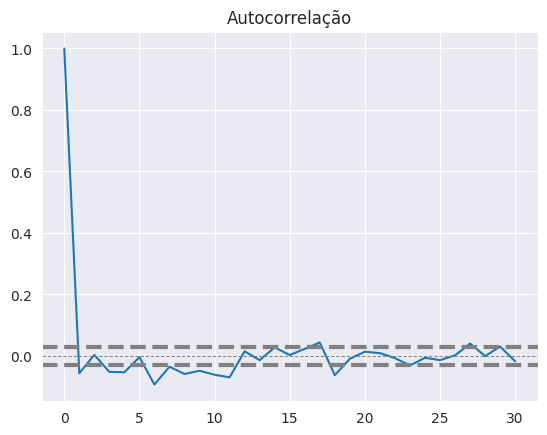

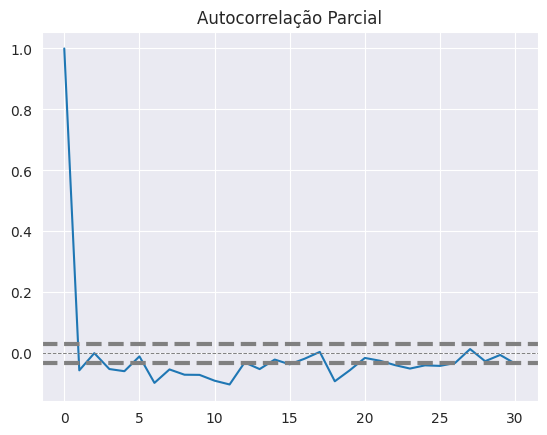

In [ ]:
#5% ACF

plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt(len(df_diff) -1)),linestyle='--',color='gray', linewidth= 3)

plt.axhline(y=0, linestyle='--',color='gray', linewidth= 0.7)

plt.axhline(y= 1.96/(np.sqrt(len(df_diff) -1)),linestyle='--',color='gray', linewidth= 3)

plt.title('Autocorrelação')
plt.show()



plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt(len(df_diff) -1)),linestyle='--',color='gray', linewidth= 3)

plt.axhline(y=0, linestyle='--',color='gray', linewidth= 0.7)

plt.axhline(y= 1.96/(np.sqrt(len(df_diff) -1)),linestyle='--',color='gray', linewidth= 3)

plt.title('Autocorrelação Parcial')
plt.show()




Conseguimos então ver os valores dos parâmetros do ARIMA nos plots acima estão em (1, 1, 1)

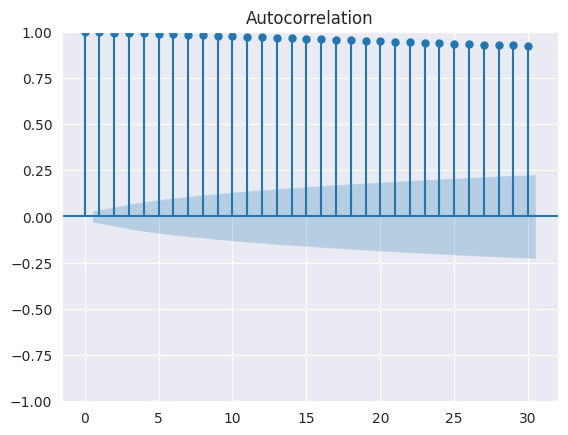

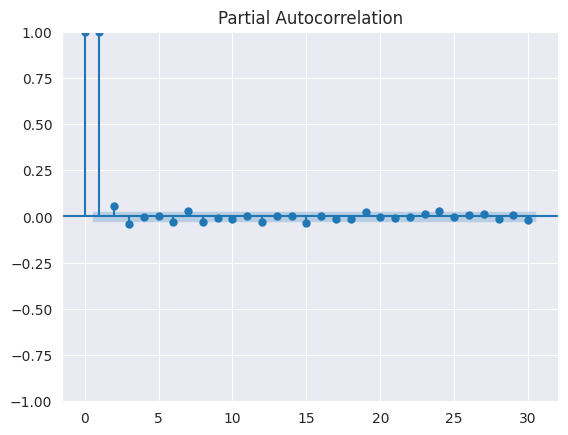

In [ ]:
plot_acf(train['Price'], lags=30)
plt.show()
print('\n')
plot_pacf(train['Price'], lags=30)
plt.show()

Esses gráficos sugerem que um modelo ARIMA(1, 1, 1) pode ser um bom ponto de partida.

**Modelo Arima**

In [ ]:
#Valores ausentes (Tratamento com interpolação)
train['Price'] = train['Price'].interpolate(method='linear')


print(train['Price'].isna().sum())

0


<ipython-input-376-5370e04e25b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price'] = train['Price'].interpolate(method='linear')


In [ ]:
#Valores ausentes (Tratamento com interpolação)
test['Price'] = test['Price'].interpolate(method='linear')


print(test['Price'].isna().sum())

0


<ipython-input-377-ec242bc8faae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Price'] = test['Price'].interpolate(method='linear')


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 4077
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -33989.519
Date:                Fri, 26 Jul 2024   AIC                          67985.039
Time:                        03:10:38   BIC                          68003.978
Sample:                    01-03-2005   HQIC                         67991.746
                         - 08-18-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3626      0.045     -8.012      0.000      -0.451      -0.274
ma.L1          0.2800      0.047      5.958      0.000       0.188       0.372
sigma2      1.026e+06   6973.302    147.084      0.0

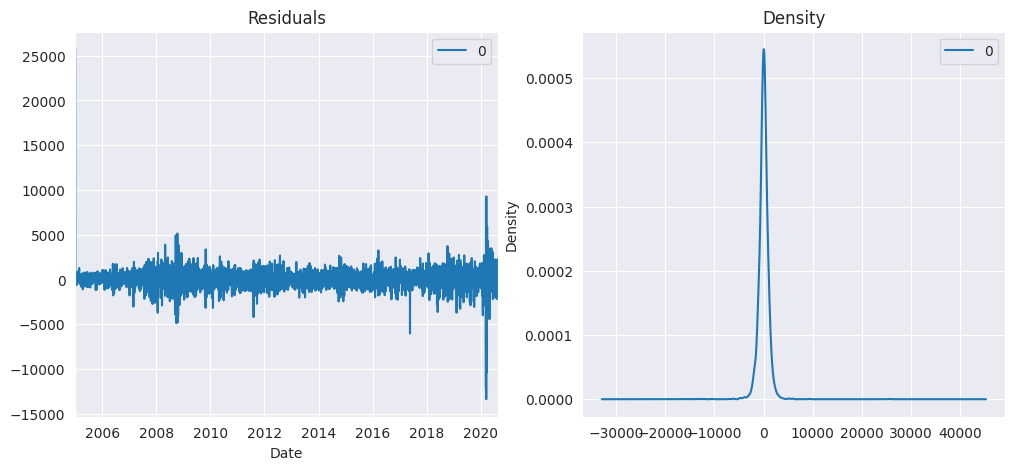

In [ ]:
# Modelo ARIMA
model = ARIMA(train, order=(1, 1, 1))  # ==> Ajustei o modelo ARIMA à série diferenciada (d=0)

result_AR = model.fit()

# Resumo do modelo
print(result_AR.summary())


# Erro residual
residuals = pd.DataFrame(result_AR.resid)
fig, ax = plt.subplots(1,2, figsize=(12, 5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()



In [ ]:
test_forecast = result_AR.get_forecast(steps=len(test))

In [ ]:
arima_forecast_values = pd.Series(test_forecast.predicted_mean, index=test.index)

In [ ]:

y_true = np.array(test)
y_pred = np.array(arima_forecast_values)

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Mean Absolute Error (MAE): {}'.format(mae))
print('Root Mean Squared Error (RMSE): {}'.format(rmse))
print('Mean Absolute Percentage Error (MAPE): {}'.format(mape))

Mean Absolute Error (MAE): 13231.583931651603
Root Mean Squared Error (RMSE): 15661.300347590897
Mean Absolute Percentage Error (MAPE): 11.0538063649428


**Modelo Arima**

**Auto Arima**

Utilizando 80% da base para treino e 20% da base para teste --> previsão de 15 dias

In [ ]:
#Valores ausentes (Tratamento com interpolação)
train['Price'] = train['Price'].interpolate(method='linear')

test['Price'] = test['Price'].interpolate(method='linear')


print(test['Price'].isna().sum())
print(train['Price'].isna().sum())


0
0


<ipython-input-383-599ded612b9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price'] = train['Price'].interpolate(method='linear')
<ipython-input-383-599ded612b9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Price'] = test['Price'].interpolate(method='linear')


In [ ]:
fit_arima = auto_arima(
    train,
    max_p=2,
    max_d=2,
    max_q=2,
    m=5,
    D=1,
    seasonal=True,
    seasonal_test='ocsb',
    d=1,
    trace=False,
    information_criterion='bic',
    stepwise=False
)

In [ ]:
print(fit_arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 4077
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -34523.050
Date:                           Fri, 26 Jul 2024   AIC                          69054.100
Time:                                   03:22:53   BIC                          69079.347
Sample:                               01-03-2005   HQIC                         69063.041
                                    - 08-18-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1018      0.006    -18.290      0.000      -0.113      -0.091
ar.S.L5       -0.6313      0.006   -108.944

In [ ]:
modelo_ajustado = fit_arima.fit(train)

In [ ]:
#Predição
test_forecast, conf_int = modelo_ajustado.predict(n_periods=15, return_conf_int=True)


In [ ]:
y_true = test.loc[test_forecast.index ]

In [ ]:
y_pred = test_forecast

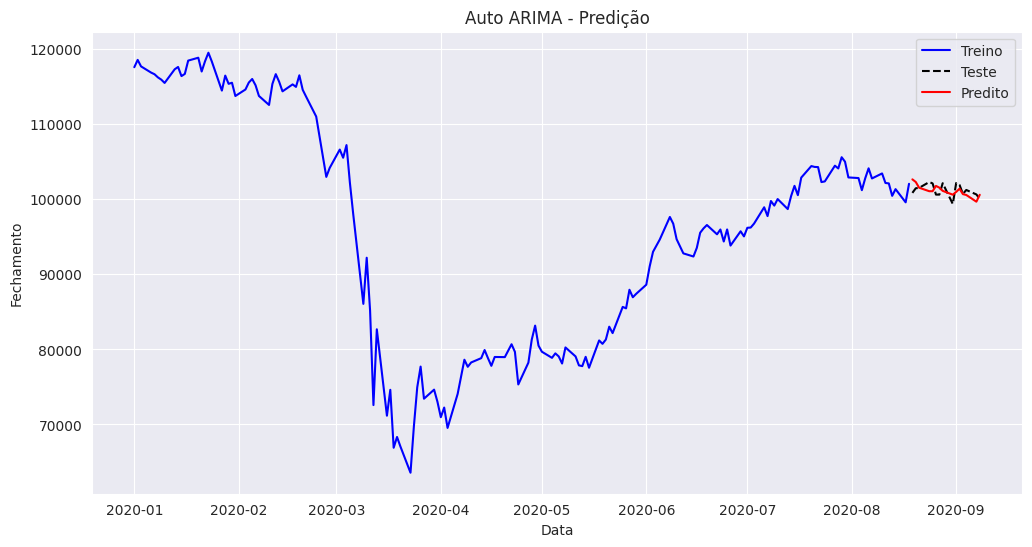

In [ ]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.loc['2020'], label='Treino', color='blue')
ax.plot(y_true.index, y_true, label='Teste', color='black', linestyle='--')
ax.plot(y_true.index, y_pred, color='red', label='Predito')

ax.legend()

ax.set_title('Auto ARIMA - Predição')
ax.set_xlabel('Data')
ax.set_ylabel('Fechamento')

plt.show()


In [ ]:
y_true = np.array(y_true)

In [ ]:

y_pred = np.array(test_forecast)

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Mean Absolute Error (MAE): {}'.format(mae))
print('Root Mean Squared Error (RMSE): {}'.format(rmse))
print('Mean Absolute Percentage Error (MAPE): {}'.format(mape))

Mean Absolute Error (MAE): 877.9911196091756
Root Mean Squared Error (RMSE): 987.8292878142527
Mean Absolute Percentage Error (MAPE): 0.8803036666595105


Base histórica como base de treino (03-01-2005 - 01/07/2024) e prevendo os próximos 15 dias

In [ ]:
df_fechamento.index = pd.to_datetime(df_fechamento.index)
data_fim = df_fechamento.index.max()
data_inicio_teste = data_fim - pd.DateOffset(days=15)

treino_hist = df_fechamento.loc[df_fechamento.index <= data_inicio_teste]

teste_15_dias = df_fechamento.loc[df_fechamento.index > data_inicio_teste]

In [ ]:
#Valores ausentes (Tratamento com interpolação)
teste_15_dias['Price'] = teste_15_dias['Price'].interpolate(method='linear')
treino_hist['Price'] = treino_hist['Price'].interpolate(method='linear')


print(treino_hist['Price'].isna().sum())
print(teste_15_dias['Price'].isna().sum())

0
0


<ipython-input-398-85a1d07ed4aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste_15_dias['Price'] = teste_15_dias['Price'].interpolate(method='linear')
<ipython-input-398-85a1d07ed4aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino_hist['Price'] = treino_hist['Price'].interpolate(method='linear')


In [ ]:
fit_arima = auto_arima(
    treino_hist,
    max_p=2,
    max_d=2,
    max_q=2,
    m=5,
    D=1,
    seasonal=True,
    seasonal_test='ocsb',
    d=1,
    trace=False,
    information_criterion='bic',
    stepwise=False
)

In [ ]:
print(fit_arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 5086
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -43408.312
Date:                           Fri, 26 Jul 2024   AIC                          86824.624
Time:                                   03:38:49   BIC                          86850.756
Sample:                               01-03-2005   HQIC                         86833.776
                                    - 07-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0812      0.006    -13.703      0.000      -0.093      -0.070
ar.S.L5       -0.6518      0.006   -107.890

In [ ]:
modelo_ajustado= fit_arima.fit(treino_hist)

In [ ]:
#Predição
test_forecast, conf_int = modelo_ajustado.predict(n_periods=16, return_conf_int=True)

In [ ]:
test_forecast

2024-07-02    125011.723388
2024-07-03    124785.770454
2024-07-04    125308.838036
2024-07-05    125495.188298
2024-07-08    126037.475051
2024-07-09    126196.731431
2024-07-10    126423.253658
2024-07-11    127215.704124
2024-07-12    127435.676192
2024-07-15    128308.953637
2024-07-16    128363.142303
2024-07-17    128466.967164
2024-07-18    129451.421841
2024-07-19    129460.744058
2024-07-22    130204.632894
2024-07-23    130370.512113
Freq: B, dtype: float64

In [ ]:
indices_forecast = test_forecast.index
indices_ajustados = indices_forecast[:-5]
test_forecast_ajustado = test_forecast.loc[indices_ajustados]

In [ ]:
y_true = teste_15_dias.loc[test_forecast_ajustado.index ]
y_pred = test_forecast_ajustado

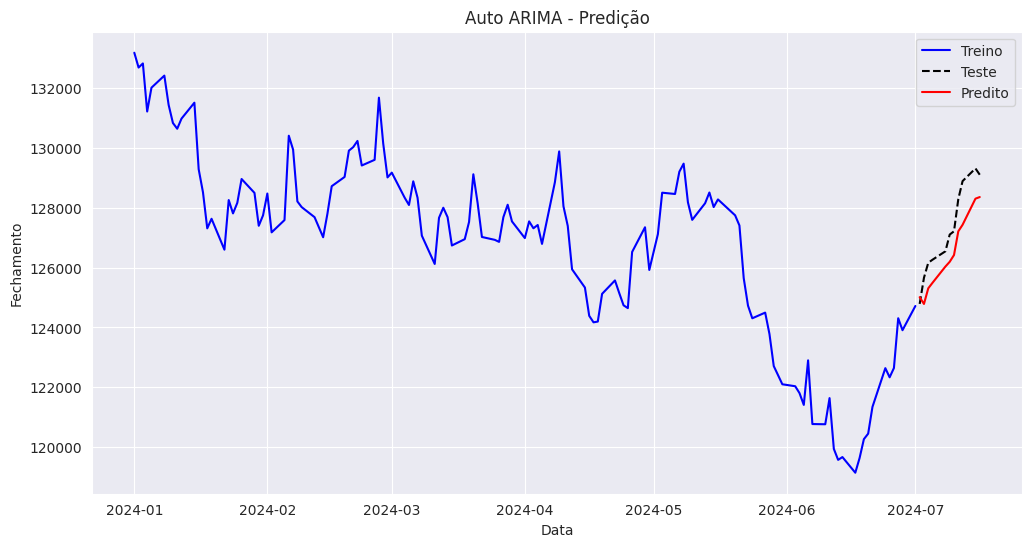

In [ ]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(treino_hist.loc['2024'], label='Treino', color='blue')
ax.plot(y_true.index, y_true, label='Teste', color='black', linestyle='--')
ax.plot(y_true.index, y_pred, color='red', label='Predito')
ax.legend()

ax.set_title('Auto ARIMA - Predição')
ax.set_xlabel('Data')
ax.set_ylabel('Fechamento')

plt.show()

In [ ]:
y_true = np.array(y_true)
y_pred = np.array(test_forecast_ajustado)

mae  = mean_absolute_error(y_true, y_pred )
rmse = np.sqrt(mean_squared_error(y_true, y_pred ))
mape = np.mean(np.abs(y_true - y_pred ) / y_true) * 100

print('Mean Absolute Error (MAE): {}'.format(mae))
print('Root Mean Squared Error (RMSE): {}'.format(rmse))
print('Mean Absolute Percentage Error (MAPE): {}'.format(mape))

Mean Absolute Error (MAE): 840.2718367411594
Root Mean Squared Error (RMSE): 891.7890859448313
Mean Absolute Percentage Error (MAPE): 1.301923909594478


**Modelo Prophet**

Utilizando 80% da base para treino e 20% da base para teste --> previsão de 15 dias

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df_fech=df[['Date','Price']]
df_fech.columns=['ds','y']

In [ ]:
df_fech.head(5)

,ds,y
0,2005-01-03,25722.0
1,2005-01-04,24848.0
2,2005-01-05,24692.0
3,2005-01-06,24367.0
4,2005-01-07,24747.0


In [ ]:
## Treino e Teste

treino_size = int(len(df_fech) * 0.8)
treino, teste = df_fech.iloc[:treino_size], df_fech.iloc[treino_size:]

In [ ]:
prophet = Prophet(daily_seasonality=True,seasonality_mode='multiplicative',seasonality_prior_scale=1000).fit(treino)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpfavsqy/ywrlbc66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpfavsqy/pfkeo8p5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39845', 'data', 'file=/tmp/tmpxpfavsqy/ywrlbc66.json', 'init=/tmp/tmpxpfavsqy/pfkeo8p5.json', 'output', 'file=/tmp/tmpxpfavsqy/prophet_modelotll13fg/prophet_model-20240726041055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:10:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:11:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
futuro=prophet.make_future_dataframe(periods=15, freq='B')
previsoes=prophet.predict(futuro)

In [ ]:
previsoes.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
3879,2020-09-08,8283.850976,100404.591292,112606.682265,8283.850976,8283.850976,11.4306,11.4306,11.4306,11.831989,...,0.570650,0.570650,0.570650,-0.169261,-0.169261,-0.169261,0.0,0.0,0.0,106298.286177
3880,2020-09-09,8286.255199,100672.665308,112394.661779,8286.255199,8286.255199,11.4306,11.4306,11.4306,11.849032,...,0.568630,0.568630,0.568630,-0.150198,-0.150198,-0.150198,0.0,0.0,0.0,106470.356723
3881,2020-09-10,8288.659423,100719.356584,112385.421767,8288.659423,8288.659423,11.4306,11.4306,11.4306,11.867440,...,0.568903,0.568903,0.568903,-0.132063,-0.132063,-0.132063,0.0,0.0,0.0,106653.828347
3882,2020-09-11,8291.063647,100917.062847,113333.259109,8291.063647,8291.063647,11.4306,11.4306,11.4306,11.898736,...,0.583061,0.583061,0.583061,-0.114925,-0.114925,-0.114925,0.0,0.0,0.0,106944.241154
3883,2020-09-14,8298.276319,101123.861481,113741.301628,8298.276319,8298.276319,11.4306,11.4306,11.4306,11.927087,...,0.566405,0.566405,0.566405,-0.069917,-0.069917,-0.069917,0.0,0.0,0.0,107272.540728


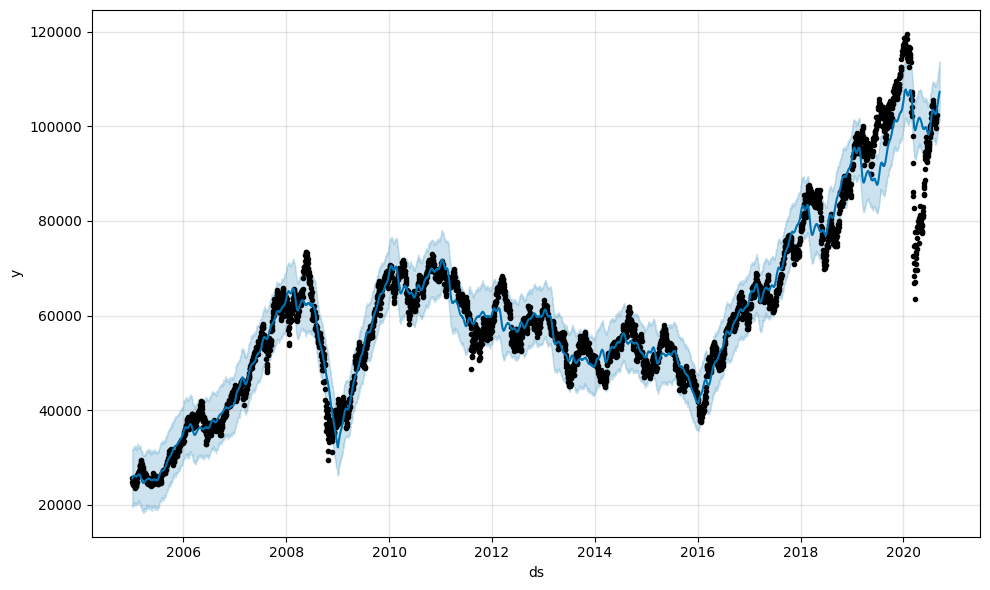

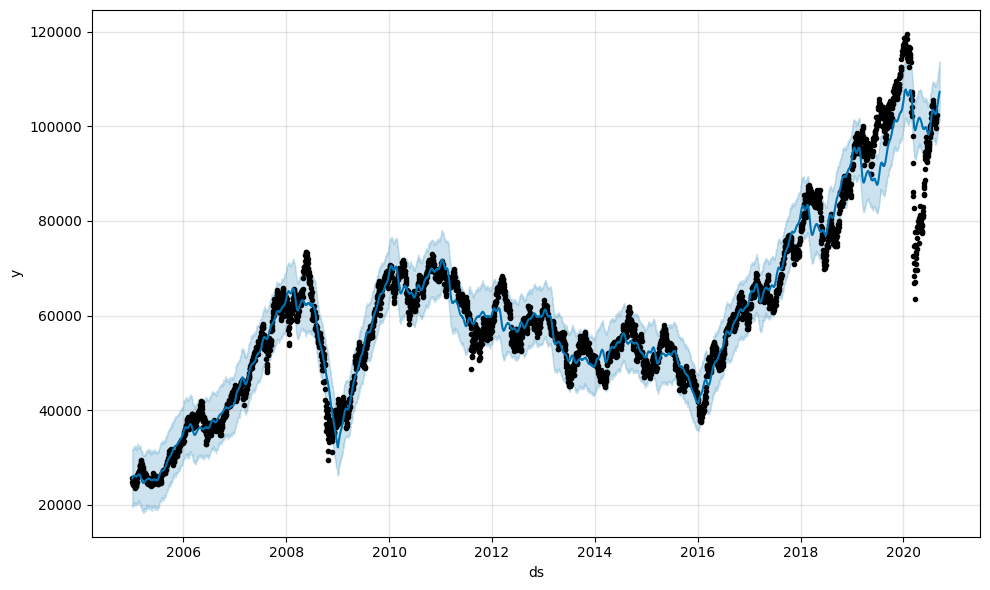

In [ ]:
prophet.plot(previsoes)

In [ ]:
previsoes[['ds','yhat','yhat_lower','yhat_upper']].tail(90)

,ds,yhat,yhat_lower,yhat_upper
3794,2020-05-11,100364.345099,94432.958052,106486.179713
3795,2020-05-12,100280.945449,94518.875204,106223.398243
3796,2020-05-13,100150.638947,93963.581784,106359.607905
3797,2020-05-14,100043.297567,94076.410999,106142.210697
3798,2020-05-15,100053.108472,94122.667168,106281.473009
...,...,...,...,...
3879,2020-09-08,106298.286177,100404.591292,112606.682265
3880,2020-09-09,106470.356723,100672.665308,112394.661779
3881,2020-09-10,106653.828347,100719.356584,112385.421767
3882,2020-09-11,106944.241154,100917.062847,113333.259109


In [ ]:
validacao=pd.DataFrame({'ds':teste['ds']})

In [ ]:
saida=prophet.predict(validacao)

In [ ]:
saida.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-08-25,8250.191842,97421.516987,109399.255052,8250.191842,8250.191842,11.4306,11.4306,11.4306,11.541378,...,0.570650,0.570650,0.570650,-0.459872,-0.459872,-0.459872,0.0,0.0,0.0,103468.771523
1,2020-08-26,8252.596066,97294.511740,109610.879243,8252.596066,8252.596066,11.4306,11.4306,11.4306,11.556517,...,0.568630,0.568630,0.568630,-0.442714,-0.442714,-0.442714,0.0,0.0,0.0,103623.858728
2,2020-08-27,8255.000290,97824.346280,109555.956037,8255.000290,8255.000290,11.4306,11.4306,11.4306,11.575221,...,0.568903,0.568903,0.568903,-0.424282,-0.424282,-0.424282,0.0,0.0,0.0,103808.457088
3,2020-08-28,8257.404513,97760.864492,110174.144360,8257.404513,8257.404513,11.4306,11.4306,11.4306,11.608909,...,0.583061,0.583061,0.583061,-0.404751,-0.404751,-0.404751,0.0,0.0,0.0,104116.865209
4,2020-08-31,8264.617185,98342.823826,110628.207675,8264.617185,8264.617185,11.4306,11.4306,11.4306,11.655593,...,0.566405,0.566405,0.566405,-0.341412,-0.341412,-0.341412,0.0,0.0,0.0,104593.630303


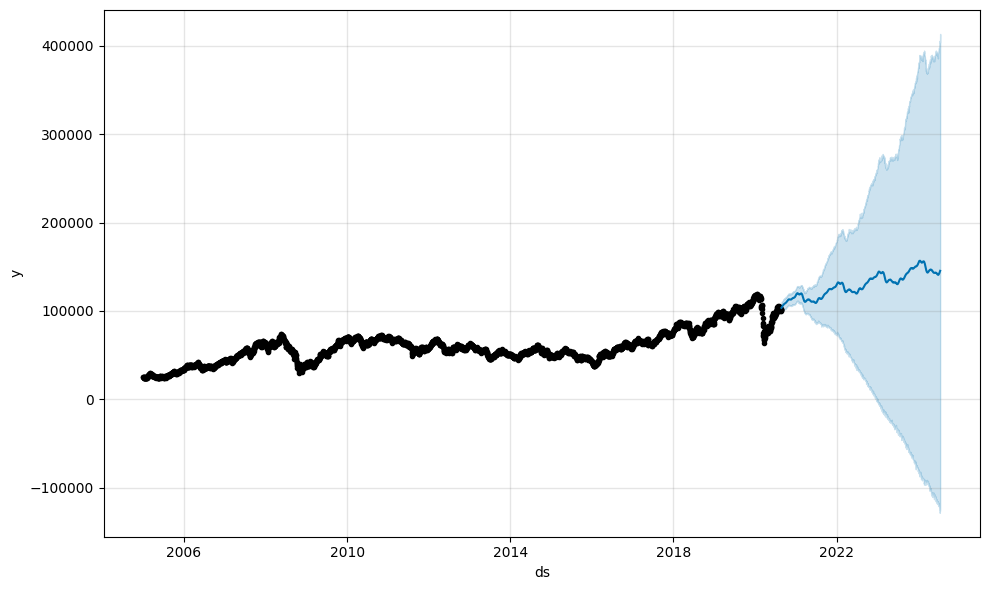

<Figure size 1000x500 with 0 Axes>

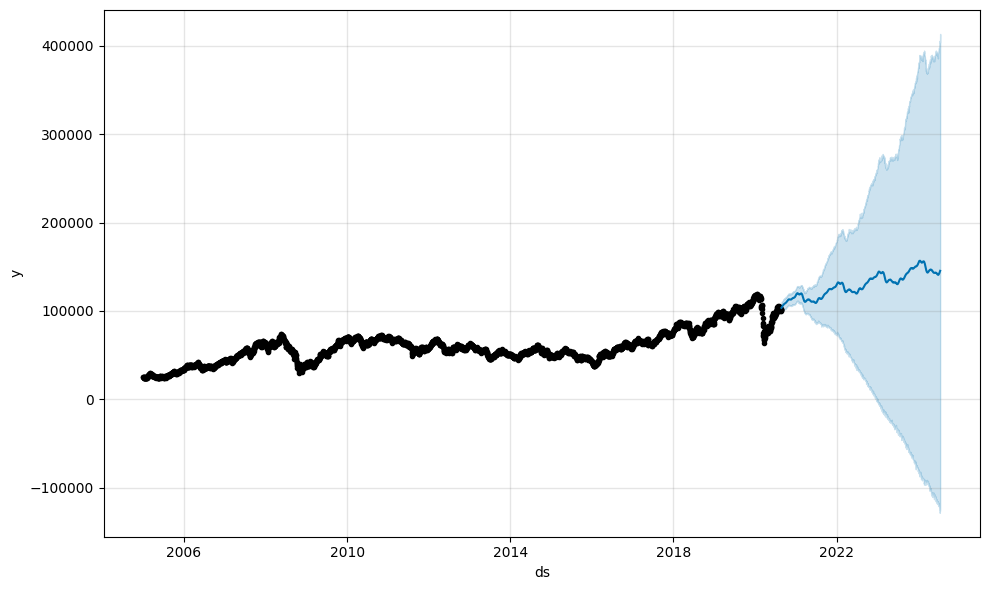

In [ ]:
plt.figure(figsize=(10, 5))
prophet.plot(saida)

In [ ]:
saida.index=teste.index

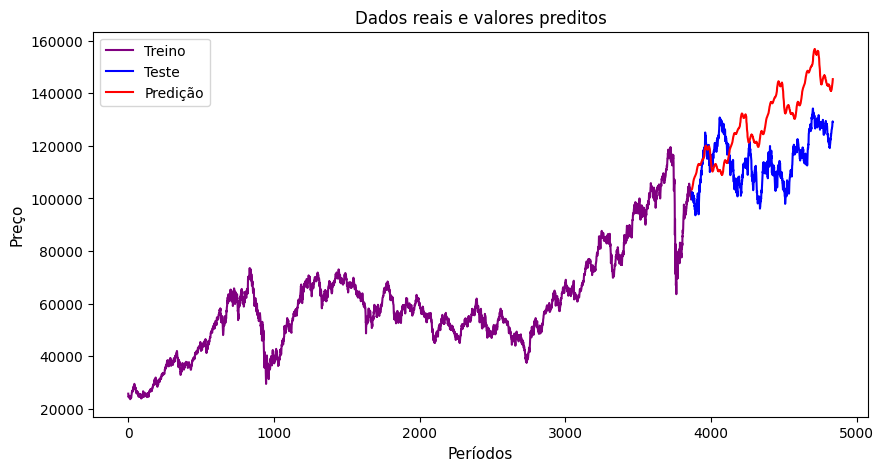

In [ ]:
plt.figure(figsize=(10,5))
treino['y'].plot(color='purple', label='Treino')
teste['y'].plot(color='blue', label='Teste')
saida['yhat'].plot(color='red', label='Predição')
plt.title('Dados reais e valores preditos',size=12)
plt.xlabel("Períodos",size=11)
plt.ylabel("Preço",size=11)
plt.legend()
plt.show()


In [ ]:
# criando a função MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape = mean_absolute_percentage_error(teste['y'], saida['yhat'])
print("MAPE",round(mape,4))

MAPE 15.6007


Nosso modelo errou aproximadamente 16%

Utilizei 95% da base para treino e 5% para teste --> Prevendo os próximos 259 dias úteis

In [ ]:
treino_size = int(len(df_fech) * 0.95)
treino_hist_prp, teste_prp = df_fech.iloc[:treino_size], df_fech.iloc[treino_size:]

In [ ]:
dias_a_prever = len(teste_prp.ds.unique())
dias_a_prever

242

In [ ]:
m = Prophet()

m.fit(treino_hist_prp)

future = m.make_future_dataframe(periods=259, freq='B')

forecast = m.predict(future)

forecast_tail = forecast.tail(5)[['ds', 'yhat']]


predict_5_days= round(forecast_tail,2)
predict_5_days



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpfavsqy/u9e0blf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpfavsqy/1efrgyj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17324', 'data', 'file=/tmp/tmpxpfavsqy/u9e0blf9.json', 'init=/tmp/tmpxpfavsqy/1efrgyj4.json', 'output', 'file=/tmp/tmpxpfavsqy/prophet_modeldkp6qd1b/prophet_model-20240726044116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat
4849,2024-07-17,116201.06
4850,2024-07-18,116275.63
4851,2024-07-19,116364.82
4852,2024-07-22,116508.02
4853,2024-07-23,116542.33


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
4850,2024-07-03,126504.753562,105084.746598,147580.430952
4851,2024-07-04,126560.012368,106082.773816,147515.182167
4852,2024-07-05,126614.287880,105784.378554,145923.750200
4853,2024-07-08,126799.804977,106608.635916,147209.608976
4854,2024-07-09,126885.354483,106409.689754,147557.665990
4855,2024-07-10,127013.884941,106940.392552,148792.203061
4856,2024-07-11,127128.668621,106085.033819,148056.358740
4857,2024-07-12,127235.677480,106111.434773,147798.991697
4858,2024-07-15,127531.512235,106782.665824,147604.626063
4859,2024-07-16,127636.271441,105598.263871,148430.306421


In [ ]:
validacao_prp=pd.DataFrame({'ds':teste_prp['ds']})

In [ ]:
saida_prp=m.predict(validacao_prp)

In [ ]:
saida_prp.index=teste_prp.index

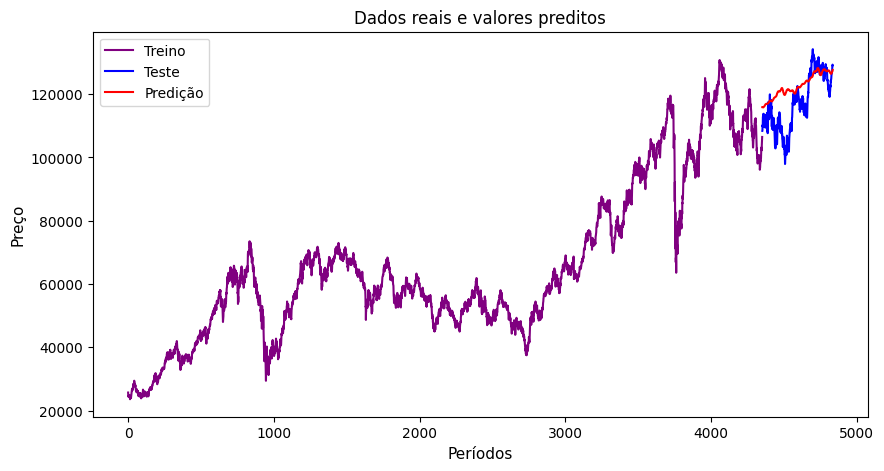

In [ ]:
plt.figure(figsize=(10,5))
treino_hist_prp['y'].plot(color='purple', label='Treino')
teste_prp['y'].plot(color='blue', label='Teste')
saida_prp['yhat'].plot(color='red', label='Predição')
plt.title('Dados reais e valores preditos',size=12)
plt.xlabel("Períodos",size=11)
plt.ylabel("Preço",size=11)
plt.legend()
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(teste_prp['y'], saida_prp['yhat'])
print("MAPE",round(mape,4))

MAPE 5.7654


O modelo errou aproximadamente 6%